# Лекция 7. Расширенный ввод/вывод

1. Расширенные атрибуты файлов
2. Фрагментированный ввод/вывод
3. Отображение файлов в память

## 1. Расширенные атрибуты файлов.

**Расширенные атрибуты** представляют собой механизм привязки к файлу пары «ключ — значение» не предусмотренные изначально. 
Например, в расширенный атрибут можно добавить хеш-значение от файла для того, чтобы контролировать его целостность. 

Расширенные атрибуты не связаны с файловой системой в том смысле, что эти приложения используют стандартный интерфейс для управления ими; интерфейс не является специфичным для какой-либо файловой системы. 

Приложения, таким образом, могут использовать расширенные атрибуты, не заботясь, в какой файловой системе находятся файлы или как эта система хранит свои ключи и значения.

Однако все-таки внедрение расширенных атрибутов значительно зависит от файловой системы. Разные файловые системы хранят расширенные атрибуты различными способами, но ядро скрывает эти различия, абстрактно представляя их с помощью системы интерфейсов расширенных атрибутов.

Файловая система ext4, например, хранит расширенные атрибуты файлов в пустом пространстве внутри индексного дескриптора файла. Эта функциональность делает считывание расширенных атрибутов значительно быстрее. Поскольку блок файловой системы, содержащий индексный дескриптор, считывается с диска в память, как только приложение обращается к файлу, то и расширенные атрибуты
«автоматически» отправляются в память и могут быть доступны без каких-либо дополнительных затрат.

Другие файловые системы, например FAT и minixfs, не поддерживают расширенные атрибуты вообще. Эти системы возвращают ENOTSUP, если к файлам направляется действие, связанное с расширенными атрибутами.

Linux не ограничивает количество ключей, их длину, размер значения или общее пространство, которое может быть занято всеми ключами или значениями, связанными с файлом. Файловые системы, однако, имеют некоторые технические пределы. Как правило, они ограничивают общий размер всех ключей и значений, связанных с данным файлом.

В еxt3, например, все расширенные атрибуты для данного файла должны укладываться в пустое пространство внутри индексного дескриптора файла и занимать в файловой системе не более одного блока. На практике это эквивалентно ограничению приблизительно 1–8 Кбайт на файл в зависимости от размера блоков в файловой системе. В XFS, наоборот, практически не имеется ограничений. 

**Каждый ключ должен начинаться с указания допустимого пространства имен, после которого следует точка и название ключа.** 

Linux в настоящее время определяет четыре пространства имен для расширенных атрибутов и может добавить новые в будущем:

- **system** — это пространство используется для реализации функциональностей ядра, использующих расширенные атрибуты, таких как списки управления доступом. Могут ли пользователи считывать или записывать информацию в эти атрибуты, зависит от используемого модуля безопасности. В худшем варианте — никакие пользователи (включая root) не могут даже читать эти атрибуты.
- **security** — данное пространство используется для внедрения модулей безопасности. Как и в предыдущем пространстве, возможность для пользователей считывать или записывать информацию в эти атрибуты зависит от используемого модуля безопасности. По умолчанию все процессы могут считывать свои атрибуты, но только процесс с CAP_SYS_ADMIN может записывать в них данные.
- **trusted** — это пространство имен хранит закрытую для доступа информацию в пользовательском пространстве. Только процесс со свойством CAP_SYS_ADMIN может считывать и записывать эти атрибуты.
- **user** — данное пространство имен — стандартное для использования большинством обычных процессов. Ядро управляет доступом к этому пространству через обычные биты разрешений для файлов. Чтобы считать значение существующего ключа, процесс должен иметь право чтения данного файла. Чтобы создать новый ключ или записать значение в существующий, процесс должен иметь право записи в данный файл. Вы можете назначить расширенные атрибуты в пользовательском пространстве имен только обычным файлам, но не символическим ссылкам или файлам устройств. 

Определяется четыре действия, которые приложение может проделать с расширенными атрибутами данного файла:

- для указанного файла возвращается список всех ключей расширенных атрибутов, назначенных файлу;
- для заданных файла и ключа возвращаются соответствующие величины;
- для известных файла, ключа и значения можно назначить это значение известному ключу;
- для указанных файла и ключа можно удалить расширенный атрибут из файла.

### Получение значения расширенного атрибута по ключу

Для этой цели предусмотрено три следующих системных вызова (синтаксис C):

In [ ]:
#include <sys/types.h>
#include <attr/xattr.h>

ssize_t getxattr (const char *path, const char *key,
 void *value, size_t size);
 
ssize_t lgetxattr (const char *path, const char *key,
 void *value, size_t size);
 
ssize_t fgetxattr (int fd, const char *key,
 void *value, size_t size);

Успешный вызов **getxattr()** сохранит значение расширенного атрибута с именем key из файла path в предоставленном пользователем буфере value, который имеет длину size байт. Он возвращает количество байт, которое составляет значение расширенного атрибута.

Если размер size равен 0, то вызов возвращает размер величины без ее сохранения в буфере value. Таким образом, установка 0 позволяет приложениям определить точный размер буфера, в котором может храниться значение ключа. Передавая этот размер, приложения могут затем передавать или менять размер буфера. 

**lgetxattr()** ведет себя аналогично getxattr() за исключением случая, когда path — символическая ссылка. Тогда вызов возвращает расширенные атрибуты самой ссылки, а не ее целевого объекта. 

**fgetxattr()** работает с файловым дескриптором fd; в остальном он ведет себя аналогично getxattr(). В случае ошибки все три вызова возвращают -1.

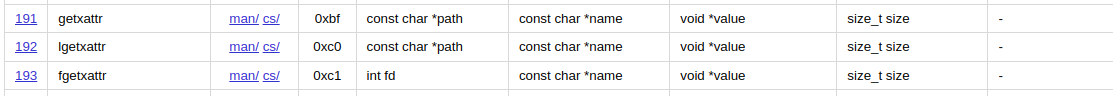

### Установка значения расширенного атрибута

Следующие три системных вызова устанавливают указанный расширенный атрибут:

In [ ]:
#include <sys/types.h>
#include <attr/xattr.h>

int setxattr (const char *path, const char *key,
 const void *value, size_t size, int flags);
 
int lsetxattr (const char *path, const char *key,
 const void *value, size_t size, int flags);
 
int fsetxattr (int fd, const char *key,
 const void *value, size_t size, int flags);

Успешный вызов **setxattr()** устанавливает расширенный атрибут key файлу path равным value, имеющего size байт длины. Поле flags управляет поведением вызова. Если в flags прописано **XATTR_CREATE** (создание расширенного атрибута) и расширенный атрибут уже существует, вызов приведет к ошибке. Если в flags прописано **XATTR_REPLACE** (замещение расширенного атрибута), а расширенных атрибутов еще нет, вызов приведет к ошибке. В ассемблере флаг **XATTR_CREATE** соответствует 1, т.е. **XATTR_CREATE** = 1, а флаг **XATTR_REPLACE** соответствует 2, т.е. **XATTR_REPLACE** = 2. Информация об этом содержится в заголовочнгом файле **xattr.h**. По умолчанию, если в flags указан 0, позволяются и создание, и замена расширенных атрибутов. Независимо от значения flags, никакие ключи, кроме указанных в key, не затрагиваются.

Вызов **lsetxattr()** работает аналогично **setxattr()**, за исключением случая, когда path — символическая ссылка. Тогда вызов устанавливает расширенные атрибуты самой ссылки, а не ее целевого объекта. В пользовательском именном пространстве атрибуты не применяются к символическим ссылкам, следовательно, этот вызов используется редко.

**fsetxattr()** работает с файловым дескриптором fd; в остальном он ведет себя аналогично **getxattr()**. В случае успеха все три системных вызова возвращают 0; при неудаче вызовы возвращают -1.

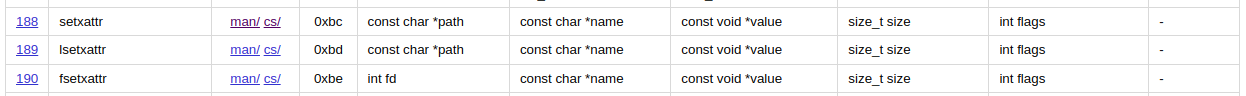

### Получение списка расширенных атрибутов файла

Следующие три системных вызова выводят весь набор ключей расширенных
атрибутов, назначенных данному файлу:

In [ ]:
#include <sys/types.h>
#include <attr/xattr.h>

ssize_t listxattr (const char *path, char *list, size_t size);

ssize_t llistxattr (const char *path, char *list, size_t size);

ssize_t flistxattr (int fd, char *list, size_t size);

Успешный вызов **listxattr()** возвращает список ключей расширенных атрибутов, связанных с файлом, определенным через path. Список хранится в буфере list, размер которого равен size байт. Системный вызов возвращает фактический размер списка в байтах.
Каждый ключ расширенного атрибута, возвращенного в списке list, заканчивается нулевым символом.

Хотя каждый ключ представляет собой традиционную, оканчивающуюся нулем строку С, чтобы пройтись по списку ключей, нужно знать его
длину (которая доступна из возвращаемой вызовом величины). 

Чтобы определить размер буфера, необходимый для размещения списка, следует вызвать одну из списочных функций с параметром size, равным 0. Это заставит функцию вернуть актуальную длину полного списка ключей. 

**llistxattr()** ведет себя аналогично listxattr(), за исключением случая, когда path — символическая ссылка. Тогда вызов обрабатывает расширенные атрибуты самой ссылки, а не ее целевого объекта. 

**flistxattr()** работает с файловым дескриптором fd; в остальном он ведет себя аналогично listxattr().
В случае неуспеха все три вызова возвращают –1.

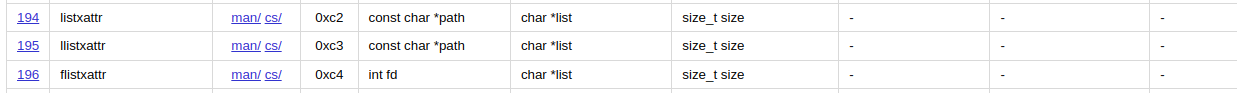

### Удаление расширенного атрибута

Наконец, следующие три системных вызова удаляют указанный ключ из указанного файла:

In [ ]:
#include <sys/types.h>
#include <attr/xattr.h>

int removexattr (const char *path, const char *key);

int lremovexattr (const char *path, const char *key);

int fremovexattr (int fd, const char *key);

Успешный вызов **removexattr()** удаляет расширенный атрибут key из файла path.

Вызов **lremovexattr()** ведет себя аналогично removexattr(), за исключением случая, когда path — символическая ссылка. Тогда вызов удаляет ключ атрибута самой
ссылки, а не ее целевого объекта. 

**fremovexattr()** работает с файловым дескриптором fd; в остальном он ведет себя аналогично **getxattr()**.

В случае успеха все три системных вызова возвращают 0; при неудаче вызовы возвращают -1.

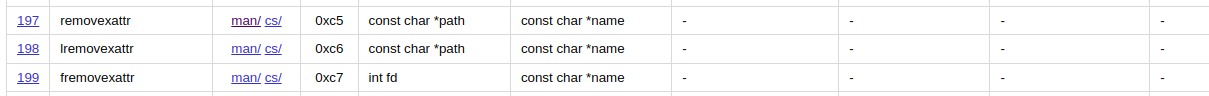

В приведенной ниже программе демонстрируется использование расширенных параметров.

Программу можно запускать в одним, двумя и тремя параметрами командной строки:
- запуск с одним параметром командной строки предполагает, что этот параметр - имя файла у которого нужно посмотреть список расширенных параметров
- запуск с двумя параметрами командной строки предполагает, что первый параметр - это имя расширенного параметра, второй - это имя файла, у которого нужно получить значение этого расширенного параметра
- запуск с тремя параметрами командной строки предполагает, что если первый параметр равен букве "d", то нужно удалить расширенный параметр, имя которого указано вторым параметром командной строки у файла, имя которого указано третьим параметром командной строки; в противном случае первый параметр командной строки интерпретируется как имя расширенного параметра, второй - как значение расширенного параметра, ну и третий как имя файла, у которого нужно добавить заданный расширенный параметр с заданным значением.

In [ ]:
;;Пример использования расширенных параметров
format elf64
public _start

len = 200

include 'func.asm'

section '.bss' writable

  buffer rb len

section '.text' executable

_start:
  ;Считываем количество параметров командной строки
   pop rcx
   cmp rcx, 2
   jne .l2

   ;Читаем список расширенных параметров
   mov rdi, [rsp+8]
   mov rsi, buffer
   mov rdx, len
   mov rax, 194
   syscall

   ;Сохраняем количество байт под расширенные параметры
   mov r8, rax
   ;Устанавливаем текущее смещение
   mov r9,0
 .loop:
   cmp r9,r8
   je .l1
   ;Находит длину текущего параметра
   mov rax, rsi
   call len_str
   add r9, rax
   inc r9
   call print_str
   call new_line
   mov rax, buffer
   add rax, r9
   mov rsi, rax
   jmp .loop

;Получаем значение расширенного атрибута
.l2:
   cmp rcx, 3
   jne .l3
   mov rdi, [rsp+16]
   mov rsi, [rsp+8]
   mov rdx, buffer
   mov r10, len
   mov rax, 191
   syscall
   mov rsi, buffer
   call print_str
   call new_line
   jmp .l1

;Устанавливаем или удаляем значение расширенного атрибута
.l3:
   cmp rcx, 4
   jne .l1
   mov rax,[rsp+8]
   cmp byte [rax], 'd'
   je .l4
   ;;Находим длину значения
   mov rax, [rsp+16]
   call len_str
   mov r10, rax
   ;inc r10
   mov rdi,[rsp+24]
   mov rsi, [rsp+8]
   mov rdx, [rsp+16]
   xor r8,r8
   mov rax, 188
   syscall
   jmp .l1

.l4:
   mov rdi,[rsp+24]
   mov rsi, [rsp+16]
   mov rax, 197
   syscall

.l1:
   call exit

Ниже приведен скриншот, демонстрирующий работоспособность программы:

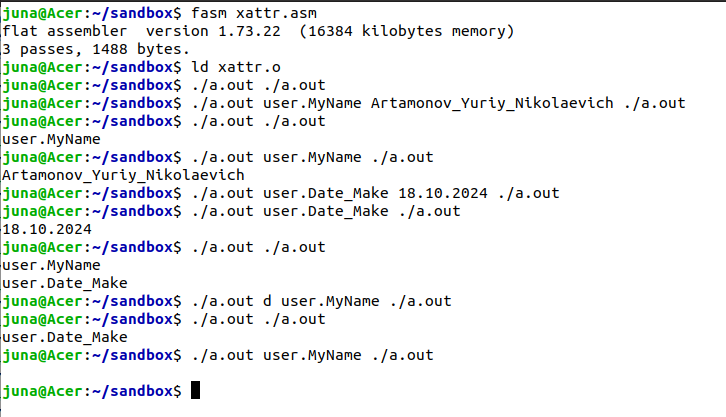

Мы знаем, что после выполнения любого системного вызова в регистр **rax** возвращается результат. Чаще всего при успешном выполнении системного вызова - это нулевое значение, иногда это какое-то положительное число. 

Однако, если это отрицательное значение, то это код ошибки. С помощью команды 

> errno -l

можно посмотреть список ошибок и соответствующие им номера:

In [ ]:
$ errno -l

EPERM 1 Операция не позволена
ENOENT 2 Нет такого файла или каталога
ESRCH 3 Нет такого процесса
EINTR 4 Прерван системный вызов
EIO 5 Ошибка ввода/вывода
ENXIO 6 Нет такого устройства или адреса
E2BIG 7 Слишком длинный список аргументов
ENOEXEC 8 Ошибка формата выполняемого файла
EBADF 9 Неправильный дескриптор файла
ECHILD 10 Нет дочерних процессов
EAGAIN 11 Ресурс временно недоступен
ENOMEM 12 Невозможно выделить память
EACCES 13 Отказано в доступе
EFAULT 14 Неправильный адрес
ENOTBLK 15 Требуется блочное устройство
EBUSY 16 Устройство или ресурс занято
EEXIST 17 Файл существует
EXDEV 18 Неверная ссылка между устройствами
ENODEV 19 Нет такого устройства
ENOTDIR 20 Это не каталог
EISDIR 21 Это каталог
EINVAL 22 Недопустимый аргумент
ENFILE 23 Слишком много открытых файлов в системе
EMFILE 24 Слишком много открытых файлов
ENOTTY 25 Неприменимый к данному устройству ioctl
ETXTBSY 26 Текстовый файл занят
EFBIG 27 Файл слишком велик
ENOSPC 28 На устройстве не осталось свободного места
ESPIPE 29 Недопустимая операция смещения
EROFS 30 Файловая система доступна только для чтения
EMLINK 31 Слишком много ссылок
EPIPE 32 Обрыв канала
EDOM 33 Числовой аргумент вне области определения
ERANGE 34 Числовой результат вне представимого диапазона
EDEADLK 35 Предотвращена тупиковая ситуация при обращении к ресурсу
ENAMETOOLONG 36 Слишком длинное имя файла
ENOLCK 37 Нет доступных блокировок
ENOSYS 38 Функция не реализована
ENOTEMPTY 39 Каталог не пуст
ELOOP 40 Слишком много уровней символьных ссылок
EWOULDBLOCK 11 Ресурс временно недоступен
ENOMSG 42 Нет сообщения желаемого типа
EIDRM 43 Идентификатор был удален
ECHRNG 44 Номер канала вне диапазона
EL2NSYNC 45 Уровень 2 не синхронизирован
EL3HLT 46 Уровень 3 остановлен
EL3RST 47 Уровень 3 сброшен
ELNRNG 48 Число ссылок вне допустимого диапазона
EUNATCH 49 Драйвер протокола не подсоединен
ENOCSI 50 Нет доступной CSI-структуры
EL2HLT 51 Уровень 2 остановлен
EBADE 52 Некорректный обмен
EBADR 53 Неверный дескриптор запроса
EXFULL 54 Обмен полный
ENOANO 55 Нет anode
EBADRQC 56 Неверный код запроса
EBADSLT 57 Некорректный слот
EDEADLOCK 35 Предотвращена тупиковая ситуация при обращении к ресурсу
EBFONT 59 Неверный формат файла со шрифтом
ENOSTR 60 Устройство не является потоком
ENODATA 61 Нет доступных данных
ETIME 62 Таймер истек
ENOSR 63 Недостаточно потоковых ресурсов
ENONET 64 Машина не в сети
ENOPKG 65 Пакет не установлен
EREMOTE 66 Это удаленный объект
ENOLINK 67 Соединение было разорвано
EADV 68 Ошибка объявления
ESRMNT 69 Ошибка Srmount
ECOMM 70 Ошибка связи при отправке
EPROTO 71 Ошибка протокола
EMULTIHOP 72 Попытка Multihop
EDOTDOT 73 Специфичная для RFS ошибка
EBADMSG 74 Неправильное сообщение
EOVERFLOW 75 Значение слишком велико для такого типа данных
ENOTUNIQ 76 Имя не уникально в сети
EBADFD 77 Дескриптор файла в плохом состоянии
EREMCHG 78 Удаленный адрес был изменен
ELIBACC 79 Невозможно получить доступ к нужной разделяемой библиотеке
ELIBBAD 80 Обращение к поврежденной разделяемой библиотеке
ELIBSCN 81 Секция .lib в a.out повреждена
ELIBMAX 82 Попытка подключить слишком много разделяемый библиотек
ELIBEXEC 83 Невозможно непосредственно выполнить разделяемую библиотеку
EILSEQ 84 Неверный или неполный многобайтовый или широкий символ
ERESTART 85 Прерванный системный вызов следует перезапустить
ESTRPIPE 86 Ошибка потоков канала
EUSERS 87 Слишком много пользователей
ENOTSOCK 88 Операция для сокета применена к не-сокету
EDESTADDRREQ 89 Требуется указать адрес назначения
EMSGSIZE 90 Сообщение слишком длинное
EPROTOTYPE 91 Неподдерживаемый тип протокола для сокета
ENOPROTOOPT 92 Протокол недоступен
EPROTONOSUPPORT 93 Протокол не поддерживается
ESOCKTNOSUPPORT 94 Неподдерживаемый тип сокета
EOPNOTSUPP 95 Неподдерживаемая операция
EPFNOSUPPORT 96 Неподдерживаемое семейство протоколов
EAFNOSUPPORT 97 Семейство адресов не поддерживается протоколом
EADDRINUSE 98 Адрес уже используется
EADDRNOTAVAIL 99 Невозможно назначить запрошенный адрес
ENETDOWN 100 Сеть не работает
ENETUNREACH 101 Сеть недоступна
ENETRESET 102 Сетевое соединение было разорвано
ECONNABORTED 103 Программа вызвала разрыв соединения
ECONNRESET 104 Соединение разорвано другой стороной
ENOBUFS 105 Недостаточно буферного пространства
EISCONN 106 Конечная точка передачи уже подсоединена
ENOTCONN 107 Конечная точка передачи не подсоединена
ESHUTDOWN 108 Невозможно отправить данные после выключения конечной точки передачи
ETOOMANYREFS 109 Слишком много ссылок: невозможно объединить
ETIMEDOUT 110 Время ожидания соединения истекло
ECONNREFUSED 111 В соединении отказано
EHOSTDOWN 112 Узел выключен
EHOSTUNREACH 113 Нет маршрута до узла
EALREADY 114 Операция уже выполняется
EINPROGRESS 115 Операция выполняется в данный момент
ESTALE 116 Устаревший дескриптор файла
EUCLEAN 117 Структуру необходимо почистить
ENOTNAM 118 Не является файлом именованного типа XENIX
ENAVAIL 119 Семафоры XENIX недоступны
EISNAM 120 Является файлом именованного типа
EREMOTEIO 121 Ошибка удаленного ввода/вывода
EDQUOT 122 Превышена дисковая квота
ENOMEDIUM 123 Носитель не найден
EMEDIUMTYPE 124 Неправильный тип носителя
ECANCELED 125 Операция отменена
ENOKEY 126 Требуемый ключ недоступен
EKEYEXPIRED 127 Время жизни ключа истекло
EKEYREVOKED 128 Ключ был отозван
EKEYREJECTED 129 Ключ был отвергнут службой
EOWNERDEAD 130 Владелец умер
ENOTRECOVERABLE 131 Состояние нельзя восстановить
ERFKILL 132 Операция не позволяется из-за RF-kill
EHWPOISON 133 В странице памяти аппаратная ошибка
ENOTSUP 95 Неподдерживаемая операция

Например, если в результате системного вызова **rax** получил значене -22, это соответствует ошибке: **EINVAL 22 Недопустимый аргумент**.

## 2. Фрагментированный ввод/вывод.

Мы рассмотрели простейшие системные вызовы, связанные с вводом, выводом. Существуют и расширенные варианты, ускоряющие операции чтения-записи. Мы рассмотрим два таких подхода: 
- фрагментированный ввод/вывод;
- отображение файлов в память.

**Фрагментированный ввод-вывод** позволяет отдельно взятому вызову записывать данные или считывать их из многих буферов одновременно. Полезен для объединения в пакеты полей из разных структур данных и для формирования транзакции ввода-вывода. Данный тип ввода-вывода получил такое название, поскольку данные в виде небольших фрагментов рассыпаны в векторе буферов, откуда программе приходится их собирать. Альтернативное название этого подхода — **векторный ввод/вывод**.

Фрагментированный ввод/вывод имеет преимущества перед обычным (линейным):
- Более логичный принцип написания кода. Если ваши данные сегментированы естественным образом — допустим, представлены в виде полей, имеющих заранее определенную структуру, векторный ввод-вывод обеспечивает интуитивно понятные манипуляции с кодом.
- Эффективность. Всего одна операция векторного ввода-вывода может заменить множество операций линейного.
- Производительность. Кроме снижения количества выполняемых системных вызовов, векторная реализация ввода-вывода может обеспечить более высокую производительность по сравнению с линейной, что достигается посредством внутрисистемной оптимизации.
- Атомарность. В отличие от ситуации с множественными линейными операциями ввода-вывода, процесс может выполнять всего одну операцию векторного ввода/вывода без риска наложения на ввод-вывод, происходящий в другом процессе.

В Linux реализованы два системных вызовов, обеспечивающих фрагментированный ввод-вывод.

Функция **readv()** считывает **count** сегментов из файлового дескриптора **fd** в буферы, описанные **iov**:

In [ ]:
#include <sys/uio.h>

ssize_t readv (int fd, const struct iovec *iov, int count);

Функция **writev()** записывает не более **count** сегментов из буферов, описанных в **iov**, в файловый дескриптор **fd**:

In [ ]:
#include <sys/uio.h>

ssize_t writev (int fd, const struct iovec *iov, int count);

Функции **readv()** и **writev()** работают так же, как и read() и write() соответственно, за тем исключением, что считывание или запись 
затрагивает сразу множество буферов.

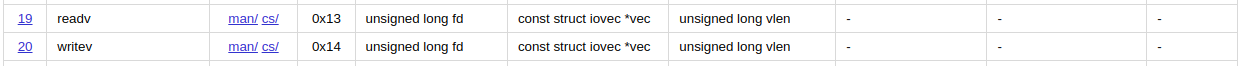

Каждая структура **iovec** описывает самостоятельный отдельный буфер, называемый **сегментом**:

In [ ]:
#include <sys/uio.h>

struct iovec{
 void *iov_base; /* указатель на начало буфера */
 size_t iov_len; /* размер буфера в байтах */
};

Набор сегментов называется **вектором**. Каждый сегмент в векторе описывает адрес и длину того буфера в памяти, в который должны быть записаны данные (или из которого они должны быть считаны). 

Функция **readv()** целиком заполняет каждый буфер, имеющий длину **iov_len** байт, после чего переходит к следующему
буферу. 

Функция **writev()** всегда записывает полный буфер **iov_len**, прежде чем перейти к следующему буферу. 

Обе функции всегда обрабатывают сегменты по порядку, начиная с **iov[0]**, затем **iov[1]** и т. д. до **iov[count-1]**.

В случае успеха функции **readv()** и **writev()** возвращают количество считанных или записанных байт соответственно. Это количество должно быть суммой всех значений **count iov_len**. При ошибке эти вызовы возвращают -1 и устанавливают errno
в соответствующее значение. 

Значение **count** должно быть больше нуля, но меньше или равно **IOV_MAX**, что определяется в <limits.h>. В современных системах Linux значение **IOV_MAX** составляет 1024. 

В целях оптимизации ядро Linux создает в стеке небольшой массив сегментов, которым пользуется, когда значение count достаточно невелико. В результате исчезает необходимость динамического выделения сегментов и производительность несколько улучшается. В настоящее время данный порог равен 8, поэтому если значение count меньше или равно 8, то векторные операции ввода-вывода очень экономно расходуют память.

Ниже представлена программа, демонстрирующая работу **writev()**. В программе используется три отдельных буфера, каждый из которых может располагаться в разных местах памяти. В структуре **iovec** мы создаем три пары: в каждой паре хранится адрес буфера и размер сохраненной в нем строки. Каждый буфер заполняется вводом с клавиатуры. Затем все буферы за раз записываются в файл "test".

In [ ]:
;;Пример использования фрагментированной записи
format elf64
public _start

include 'func.asm'

section '.data' writable

name_file db "test",0

section '.bss' writable

buffer1 rb 1000
buffer2 rb 1000
buffer3 rb 1000

Struc iovec
{
  .field1 rq 1
  .count1 rq 1
  .field2 rq 1
  .count2 rq 1
  .field3 rq 1
  .count3 rq 1
}

mystr iovec

section '.text' executable

_start:

   ;открываем файл
   mov rax, 2
   mov rdi, name_file
   mov rsi, 1101o
   mov rdx, 777o
   syscall
   mov r9, rax

   ;читаем ввод с клавиатуры
   mov rsi, buffer1
   call input_keyboard

   mov rsi, buffer2
   call input_keyboard

   mov rsi, buffer3
   call input_keyboard

   ;заполняем структуру
   mov [mystr.field1], buffer1
   mov rax, buffer1
   call len_str
   mov [mystr.count1], rax

   mov [mystr.field2], buffer2
   mov rax, buffer2
   call len_str
   mov [mystr.count2], rax

   mov [mystr.field3], buffer3
   mov rax, buffer3
   call len_str
   mov [mystr.count3], rax

   ;реализуем системный вызов writev
   mov rdi, r9
   mov rsi, mystr
   mov rdx,3
   mov rax,20
   syscall

   ;;Системный вызов close
   mov rdi, r9
   mov rax, 3
   syscall
   
   ;выход
   call exit

Ниже представлен скриншот, демонстрирующий работу этого системного вызова:

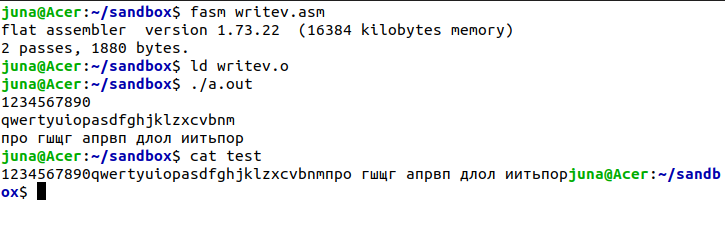

Аналогичным образом можно использовать фрагментированноое чтение из файла.

## 3. Отображение файлов в память.

Для стандартного файлового ввода-вывода ядро Linux предоставляет интерфейс, позволяющий отображать файл в память. Это означает, что существует однозначное соответствие между адресом в памяти и словом в файле.

Благодаря этому программист может обращаться к файлу напрямую через память точно так же, как и к любому другому фрагменту данных, находящемуся в памяти. Можно даже разрешить запись в область памяти так, чтобы записываемые данные прозрачно отображались на файл, расположенный на диске.

Cистемный вызов **mmap()** предназначен для отображения объектов в память. 

При вызове **mmap()** мы указываем ядру отобразить в память **len** байт объекта, представленного файловым дескриптором **fd** и начинающийся в файле со смещения в **offset** байт. Если включить **addr**, то данное значение указывает адрес в памяти,
который имеет приоритет при выборе начальной точки отображения. Права доступа регламентируются в **prot**, а дополнительное поведение можно определить с помощью **flags**:

In [ ]:
#include <sys/mman.h>

void * mmap (void *addr, size_t len, int prot, int flags, int fd, off_t offset);

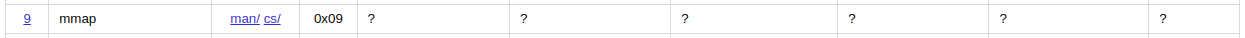

Параметр **addr** подсказывает ядру, с какого места в памяти лучше всего начать отображение файла. Это всего лишь рекомендация; большинство пользователей передают здесь значение 0. Вызов возвращает конкретный адрес из памяти — тот, с которого будет начинаться отображение.

Параметр prot описывает желательную степень защиты памяти при отображении. Он может иметь значение **PROT_NONE**, при котором запрещается доступ к страницам, участвующим в процессе отображения (почти не применяется!), либо иметь один или несколько следующих флагов, перечисляемых методом побитового «ИЛИ»:
- **PROT_READ** — страницы доступны для чтения;
- **PROT_WRITE** — страницы доступны для записи;
- **PROT_EXEC** — страницы доступны для выполнения.
Соответствие названий числовым значениям хранится в заголовочном файле **mman.h**:

In [ ]:
#define PROT_READ        0x1                /* Page can be read.  */
#define PROT_WRITE        0x2                /* Page can be written.  */
#define PROT_EXEC        0x4                /* Page can be executed.  */
#define PROT_NONE        0x0                /* Page can not be accessed.  */

Желаемая степень защиты памяти не должна противоречить режиму, в котором был открыт файл. Например, если программа открывает файл только для чтения, то в **prot** нельзя указывать **PROT_WRITE**.

Аргумент flags описывает тип отображения и некоторые элементы соответствующего поведения. Он представляет собой побитовое «ИЛИ» следующих значений.
- **MAP_FIXED** — приказывает mmap() считать параметр **addr** обязательным, а не рекомендательным. Если ядро не может начать отображение с указанного адреса, то вызов завершается ошибкой. Если параметры адреса и длины отображаемой области накладываются на имеющееся отображение, то отображенные ранее страницы сбрасываются и заменяются новыми. Такой вариант требует точнейшего ориентирования в адресном пространстве процесса, поэтому использовать его настоятельно не рекомендуется.
- **MAP_PRIVATE** — файл отображается только в режиме копирования, любые изменения, сделанные в памяти данным процессом, не учитываются ни в самом файле, ни в отображениях, используемых другими процессами.
- **MAP_SHARED** — процесс использует отображение совместно со всеми другими процессами, отображающими тот же файл. Запись в отображение эквивалентна записи в файл. Считывание из отображения будет учитывать записи, сделанные другими процессами.

Необходимо задать MAP_SHARED или MAP_PRIVATE, но не два этих флага одновременно. Полный состав флагов и их соответствий кодам также указан в заголовочном файле **mman.h**.

In [ ]:
#define MAP_SHARED        0x01                /* Share changes.  */
#define MAP_PRIVATE        0x02                /* Changes are private.  */
#define MAP_FIXED        0x10                /* Interpret addr exactly.  */

Страница — это единица детализации (разбивки) в блоке управления памятью (Memory Management Unit, MMU). Следовательно, это мельчайшая единица памяти, для которой могут быть заданы собственное поведение и права доступа. 

Системный вызов **mmap()** оперирует страницами. Значения параметров **addr** и **offset** должны быть выровнены по размерам страницы. Таким образом, они должны быть целочисленными и кратными размеру страницы.

Если параметр **len**, предоставленный вызывающей стороной, не выровнен по размерам страницы — например, потому, что размер описываемого им файла не кратен размеру страницы, — то отображения округляются до ближайшей полной страницы. Байты этой добавленной памяти, расположенные между последним допустимым файлом и концом отображаемой области, заполняются нулями. Каждое считывание из такой добавленной области возвратит только нули. Любые попытки записать информацию в эту область никак не отразятся на базовом файле, даже если он отображается с флагом **MAP_SHARED**.

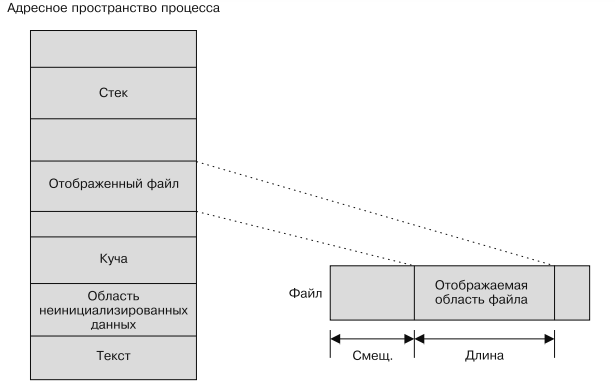

Узнать размер страницы можно с помощью следующей простой программы на С:

In [1]:
#include <stdio.h>
#include <unistd.h>
int main() {
  printf("%lu\n", sysconf(_SC_PAGESIZE));
}

4096


В случае успеха вызов mmap() возвращает расположение отображаемой области. При ошибке он возвращает MAP_FAILED и устанавливает errno соответствующее значение. Вызов mmap() никогда не возвращает 0.

В Linux предоставляется вызов **munmap()**, позволяющий удалять отображение, созданное при вызове **mmap()**:

In [ ]:
#include <sys/mman.h>

int munmap (void *addr, size_t len);

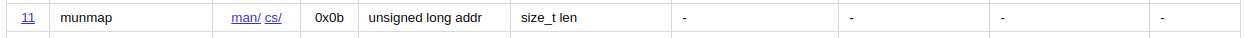

Вызов удаляет все отображения, в которых содержатся страницы, расположенные в любой части адресного пространства процесса, начинающейся с **addr**  и на протяжении **len** байт. Как только отображение удалено, область памяти, которая была с ним ассоциирована, больше не является допустимой и при последующих попытках обращения к ней генерируется сигнал SIGSEGV.

Как правило, мы передаем **munmap()** возвращаемое значение и параметр len, использовавшиеся при последнем вызове mmap().

При успехе **munmap()** возвращает 0. При ошибке он возвращает -1 и присваивает errno соответствующее значение. Единственное стандартное значение errno в данном случае — EINVAL, оно указывает, что один или несколько параметров имеют недопустимые значения.

Ниже представлен пример отображения файла в память: с файлом связывается область памяти, куда мы записываем текст, вводимый с клавиатуры.

In [ ]:
;;Пример использования отображения в память
format elf64
public _start

include 'func.asm'

section '.data' writable

name_file db "test",0

section '.text' executable

_start:

;;Открываем файл на запись-чтение
   mov rax, 2
   mov rdi, name_file
   mov rsi, 2
   mov rdx, 777o
   syscall
   mov r12, rax
   
;;выполняем отображение файла в память
   mov rdi, 0    ;начальный адрес выберет сама ОС
   mov rsi, 4096 ;задаем длину равную размеру страницы
   mov rdx, 0x3  ;совмещаем флаги PROT_READ | PROT_WRITE
   mov r10,0x01  ;задаем режим MAP_SHARED
   mov r8, r12   ;указываем файловый дескриптор
   mov r9, 0     ;задаем нулевое смещение
   mov rax, 9    ;номер системного вызова mmap
   syscall
   
   mov rsi, rax  ;Сохраняем адрес памяти, куда отобразился файл
   
   call input_keyboard  ;вводим с клавиатуры в файл


;;выполняем системный вызов munmap
   mov rdi, rsi
   mov rsi, 4096
   mov rax, 11
   syscall

;;Системный вызов close
   mov rdi, r12
   mov rax, 3
   syscall
   call exit

Ниже представлен скриншот, демонстрирующий работу программы:

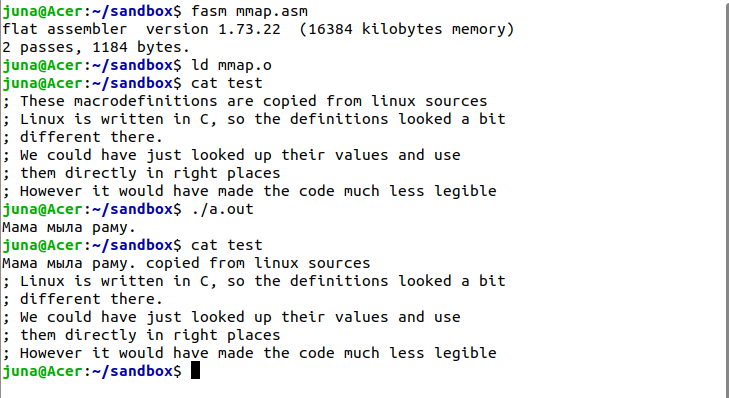

**Преимущества mmap()**

Если манипулировать файлами с помощью вызова mmap(), мы получаем некоторые преимущества по сравнению с использованием стандартных системных вызовов **read() и write()**:
- При чтении файла, отображенного в память, или при его записи мы обходимся без лишнего копирования, которое выполняется при применении системных вызовов read() или write(), требующих переноса информации в пользовательский буфер и из него.
- Кроме возможных отказов страниц при записи в файл, отображаемый в память, и при его считывании нет никаких издержек, связанных с дополнительными системными вызовами и переключением контекста. Эти операции не сложнее, чем обычные обращения к памяти.
- Когда несколько процессов отображают в память один и тот же объект, информация из этого объекта совместно используется всеми процессами. Отображения, предназначенные только для чтения, а также разделяемые отображения для записи совместно используют страницы, которые еще не были скопированы при записи.
- Позиционирование в ходе отображения сводится к обычным манипуляциям с указателем. Системный вызов lseek() в данном случае не нужен.

**Недостатки mmap()**

Есть несколько негативных моментов, которые необходимо учитывать при использовании **mmap()**.
- По своей величине отображения в памяти всегда являются целочисленными кратными размеру страницы, поэтому разница между размером базового файла и целым количеством страниц приходится на напрасно расходуемое пустое место. Если вы работаете с небольшими файлами, то на такое потерянное пространство может приходиться существенный процент отображаемой области. Например, при работе с 4-килобайтными страницами при отображении 7 байт мы теряем 4089 байт при каждом отображении.
- Отображения в памяти должны вписываться в адресное пространство процесса. Если процесс работает в 32-битном пространстве, то при значительном количестве отображений разного размера адресное пространство может сильно дробиться и в нем сложно будет найти сравнительно крупную непрерывающуюся свободную область. Эта проблема сохраняется и в 64-битном адресном пространстве, но там она проявляется значительно слабее.
- Возникают издержки, связанные с созданием и поддержкой отображений, находящихся в памяти, и ассоциированных с ними структур данных, расположенных в ядре. Особенно это касается больших и часто используемых файлов.

### Изменение размеров отображения

Linux предоставляет системный вызов **mremap()**, позволяющий увеличивать или уменьшать размер заданного отображения. 

In [ ]:
#define _GNU_SOURCE
#include <sys/mman.h>

void * mremap (void *addr, size_t old_size, size_t new_size, unsigned long flags);

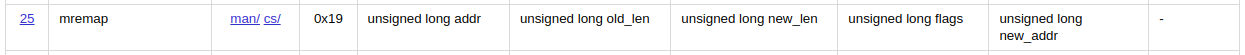

Вызов **mremap()** расширяет или сужает площадь отображения в области памяти [addr,addr+old_size], устанавливая новое значение **new_size**. Потенциально ядро может одновременно переместить отображение — в зависимости от того, имеется
ли в адресном пространстве процесса необходимое для этого место, а также в зависимости от значения **flags**.

Параметр **flags** может иметь значение 0 или **MREMAP_MAYMOVE = 1**. Второе значение указывает, что при необходимости ядро может переместить область отображения, если это нужно для изменения размеров. При значительном изменении размеров для успешного выполнения такой операции ядро должно иметь возможность перемещать область отображения.

В случае успеха **mremap()** возвращает указатель на область отображения памяти, размер которой только что был изменен.
При ошибке эта функция возвращает **MAP_FAILED** и устанавливает в **errno** код ошибки.

### Изменение защиты отображения

Имеется системный вызов **mprotect()**, позволяющий программам изменять права доступа к имеющимся областям памяти:

In [ ]:
#include <sys/mman.h>

int mprotect (const void *addr, size_t len, int prot);

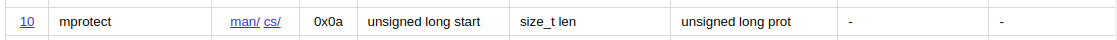

Вызов **mprotect()** изменяет режим защиты для страниц памяти, содержащихся в области [addr,addr+len], где параметр **addr** выровнен по размеру страниц. Параметр **prot** принимает те же значения, что и при передаче этого параметра **mmap()**: **PROT_NONE, PROT_READ, PROT_WRITE и PROT_EXEC**. Например, если область памяти доступна для чтения, а **prot** установлен только как **PROT_WRITE**, то данный вызов сделает область доступной лишь для записи.

В некоторых системах mprotect() может оперировать только такими отображениями в памяти, которые были созданы с помощью mmap(). В Linux mprotect() может работать с любой областью памяти.

Возвращаемые значения и коды ошибок. При успехе mprotect() возвращает 0. При ошибке эта функция возвращает -1 и устанавливает в errno код ошибки.

### Синхронизация файла с помощью отображения

Linux  предоставляет также системный вызов **msync**:

In [ ]:
#include <sys/mman.h>
int msync (void *addr, size_t len, int flags);

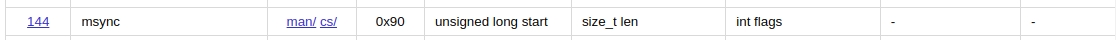

Вызов **msync()** сбрасывает обратно на диск любые изменения, сделанные в файле, отображенном с помощью **mmap()**, синхронизируя отображенный файл с самим отображением. В данном случае файл или его подмножество, ассоциированное с отображением (от адреса в памяти addr до len байт), синхронизируется с диском.

Аргумент addr должен быть выровнен по размерам страниц. Обычно он представляет собой значение, возвращаемое от предыдущего вызова **mmap()**.

Без вызова **msync()** не гарантируется, что система успеет записать грязную информацию обратно на диск прежде, чем отображение файла прекратится. Это отличается от поведения **write()**, когда буфер загрязняется в процессе записи и ставится в очередь для переноса на диск. При записи в отображение в памяти процесс изменяет страницы непосредственно в страничном кэше ядра, причем само ядро в этом не участвует. После этого ядро может сразу не синхронизировать страничный кэш и информацию на диске.

Параметр flags управляет ходом процесса синхронизации. Он может представлять собой побитовое «ИЛИ» либо следующие значения.
- **MS_SYNC = 4** — указывает, что синхронизация должна быть синхронной. Вызов msync() не вернется, пока все страницы не будут записаны на диск.
- **MS_ASYNC = 1** — определяет, что синхронизация должна быть асинхронной. Обновление назначается планировщиком, но вызов msync() возвращается сразу, не дожидаясь завершения всех операций записи.
- **MS_INVALIDATE = 2** — указывает, что все другие копии отображения должны быть признаны недействительными. Любые последующие обращения к каким-либо отображениям этого файла будут отражать наиболее актуальную синхронизированную информацию с диска.

Можно указать MS_ASYNC или MS_SYNC, но не два этих флага одновременно.

В случае успеха **msync()** возвращает 0. При ошибке вызов возвращает -1 и устанавливает errno в соответствующее значение.

### Извещения об отображении.

В Linux предоставляется системный вызов **madvise()**, с помощью которого процессы могут извещать ядро или подсказывать ему, как предполагается использовать данное отображение. На основании этой информации ядро может оптимизировать поведение, чтобы пользоваться преимуществами конкретного варианта отображения. Конечно, ядро Linux динамически корректирует свое поведение и, как правило, обеспечивает оптимальную производительность без явных извещений такого рода. Тем не менее, давая подсказки, мы можем добиться желаемого кэширования и опережающего считывания при некоторых типах нагрузки.

Вызов **madvise()** сообщает ядру, как следует обращаться со страницами, находящимися в памяти по адресу **addr** и далее до **len** байт:

In [ ]:
#include <sys/mman.h>
int madvise (void *addr, size_t len, int advice);

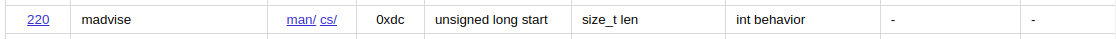

Если **len** равно 0, то ядро применит рекомендацию ко всей области отображения, начиная с адреса **addr**. Параметр **advice** ограничивает область действия рекомендации и может иметь одно из следующих значений:
- **MADV_NORMAL = 0** — приложение не получает конкретной рекомендации, как работать с данной областью памяти; обработка должна проходить в обычном режиме;
- **MADV_RANDOM = 1** — приложение планирует обращаться к страницам из указанного диапазона в случайном (произвольном) порядке;
- **MADV_SEQUENTIAL = 2** — приложение будет обращаться к страницам из указанного диапазона последовательно, от самого нижнего до самого верхнего адреса;
- **MADV_WILLNEED = 3** — в ближайшем будущем приложение обратится к страницам из указанного диапазона;
- **MADV_DONTNEED = 4** — в ближайшем будущем приложение не планирует обращаться к страницам из указанного диапазона.
Подробная информация представлена в **mman.h**

In [ ]:
/* Advice to `madvise'.  */
#ifdef __USE_BSD
# define MADV_NORMAL          0        /* No further special treatment.  */
# define MADV_RANDOM          1        /* Expect random page references.  */
# define MADV_SEQUENTIAL  2        /* Expect sequential page references.  */
# define MADV_WILLNEED          3        /* Will need these pages.  */
# define MADV_DONTNEED          4        /* Don't need these pages.  */
# define MADV_REMOVE          9        /* Remove these pages and resources.  */
# define MADV_DONTFORK          10        /* Do not inherit across fork.  */
# define MADV_DOFORK          11        /* Do inherit across fork.  */
# define MADV_MERGEABLE          12        /* KSM may merge identical pages.  */
# define MADV_UNMERGEABLE 13        /* KSM may not merge identical pages.  */
# define MADV_HWPOISON          100        /* Poison a page for testing.  */
#endif

Конкретные модификации поведения, выбираемые ядром в ответ на такую рекомендацию, зависят от реализации системы. Ядро Linux версии 2.6 и выше следующим образом реагирует на перечисленные значения **advice**:

- **MADV_NORMAL** — ядро работает в обычном режиме, выполняя опережающее считывание в умеренном объеме;
- **MADV_RANDOM** — ядро отключает опережающее считывание, при каждой физической операции считывания захватывается лишь минимальный объем данных;
- **MADV_SEQUENTIAL** — ядро выполняет агрессивное опережающее считывание;
- **MADV_WILLNEED** — ядро инициирует опережающее считывание, копируя указанные страницы в память;
- **MADV_DONTNEED** — ядро высвобождает все ресурсы, связанные с указанными страницами в памяти, а также сбрасывает все грязные и еще не синхронизированные страницы; при последующих обращениях к отображенным данным эта информация будет подкачиваться из файла с резервной копией или (при анонимных отображениях) заполнять нулями запрошенные страницы;
- **MADV_DONTFORK** — указанные здесь страницы не копируются в дочерний процесс на протяжении всего ветвления; этот флаг доступен только в версии ядра Linux 2.6.16 и выше, он нужен при управлении DMA-страницами, в других случаях используется редко.

Когда ядро Linux считывает файлы с диска, оно выполняет оптимизацию, называемую опережающим считыванием. Когда делается запрос к определенному фрагменту файла, ядро также считывает и следующий за ним фрагмент. Если затем делается запрос к этому заблаговременно прочитанному фрагменту файла (именно это и происходит при последовательном считывании файла), то ядро вернет запрошенные данные без какой-либо задержки. Поскольку у дисков есть буферы дорожек (так как диски выполняют и собственное опережающее считывание), а еще потому, что файлы располагаются на диске в той или иной последовательности, данная оптимизация получается малозатратной.

Небольшое опережающее считывание обычно целесообразно, но для достижения оптимального результата необходимо определить, в каком именно объеме требуется такое считывание. Если файл обрабатывается последовательно, то окно опережающего считывания лучше сделать шире. Если же доступ к файлу происходит в произвольном порядке, то опережающее считывание будет практически бесполезным.

В случае успеха madvise() возвращает 0. При ошибке он возвращает -1 и присваивает errno соответствующее значение.